In [7]:
import pandas as pd
import numpy as np
import xarray as xr
import pdb
import matplotlib.pyplot as plt
import cartopy
from utils import u_plot as up, u_darrays
import cartopy.crs as ccrs
import os
import matplotlib as mpl
import pickle as pkl
from utils import constants as cnst, u_darrays, u_grid, u_plot
from scipy.ndimage.measurements import label
import ipdb

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [3]:
ts = xr.open_dataset(cnst.CHIRPS + "/global/chirps-v2.0.monthly.nc")
WA = [-15,15,4,10]
SA = [5,55,-40,0]

In [4]:
mean_years = ts.sel(longitude=slice(SA[0], SA[1]), latitude=slice(SA[2], SA[3]))

#mean_years = u_darrays.flip_lat(mean_years)
mean_years = (mean_years['precip'])[(mean_years['time.month']>=11) | (mean_years['time.month']<=1)]

In [9]:
mean_years

<xarray.DataArray 'precip' (year: 39, latitude: 800, longitude: 1000)>
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       ...,

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 -39.975 -39.925 ... -0.07500076 -0.025001526
  * longitude  (longitude) float32 5.024994 5.074997 ... 54.925003 54.97499
  * year       (year) int64 1981 1982 1983 1984 1985 ... 2016 2017 2018 2019

In [8]:
mean_years = mean_years.groupby('time.year').mean('time')

KeyError: 'time'

In [10]:
mean_y = u_grid.refactor_da(mean_years, 0.25)


In [17]:
mask = np.where(np.isnan(mean_y.values))

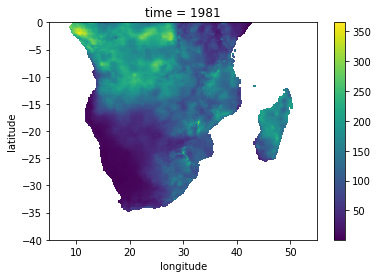

In [14]:
mean_y[0,:,:].plot.pcolormesh()

In [18]:
clim = mean_y.mean('time')
mean_y.values[mask] = 0

/home/ck/miniconda3/lib/python3.5/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [25]:
mean_y

<xarray.DataArray (time: 39, latitude: 200, longitude: 250)>
array([[[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]],

       [[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]],

       ...,

       [[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]],

       [[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]]], dtype=float32)
Coordinates:
  * time       (time) int64 1981 1982 1983 1984 1985 ... 2016 2017 2018 2019
  * latitude   (latitude) float64 -39.9 -39.7 -39.5 ... -0.5006 -0.3006 -0.1006
  * longitude  (longitude) float64 5.1 5.3 5.5 5.7 5.9 ... 54.3 54.5 54.7 54.9

In [21]:
def calc_trend(mean_years, method='mk', sig=False):
    # stack lat and lon into a single dimension called allpoints
    datastacked = mean_years.stack(allpoints=['latitude', 'longitude'])

    # apply the function over allpoints to calculate the trend at each point
    print('Entering trend calc')

    alpha = 0.05
    # NaNs means there is not enough data, slope = 0 means there is no significant trend.
    if method=='mk':
        dtrend = datastacked.groupby('allpoints').apply(u_darrays.linear_trend_mk, alpha=alpha, eps=0.0001,nb_missing=10)
        dtrend = dtrend.unstack('allpoints')
        if sig:
            (dtrend['slope'].values)[dtrend['ind'].values==0] = 0
            
    return dtrend

In [22]:
trend=calc_trend(mean_y)

Entering trend calc


/home/ck/miniconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/ck/miniconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [50]:
trend['slope'].values = trend['slope'].values*10

In [52]:
trend['slope'].values[trend['pval'].values>0.05] = 0

In [105]:
## a clean way of plotting - use matplotlib functions directly:

def draw_map(data, lon, lat, title=None,  mask_sig=None, quiver=None, contour=None, contour2=None, cbar_label=None, **kwargs):
    f=plt.figure(figsize=(10,8), dpi=300)  # this opens a plot window
    ax = f.add_subplot(111, projection=ccrs.PlateCarree())  # this opens a new plot axis
    mapp = ax.contourf(lon, lat, data, transform=ccrs.PlateCarree(),**kwargs)  # this is the actual plot
    
    ## mask for significance indicator
    if mask_sig is not None:
         plt.contourf(lon, lat, mask_sig, colors='none', hatches='.',
                     levels=[0.5, 1], linewidth=0.1)
    
    ## quiver list
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'], scale=quiver['scale'])
    ## additional contour on plot   
    if contour is not None:
        con = ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], colors='k', linewidths=0.5 )
        plt.clabel(con, inline=True, fontsize=7, fmt='%1.1f')
        
    if contour2 is not None:
        con = ax.contour(contour2['x'], contour2['y'], contour2['data'], levels=contour2['levels'], colors='r', linewidths=0.5 )
        plt.clabel(con, inline=True, fontsize=7, fmt='%1.1f')
    
    ax.coastlines()   ## adds coastlines
    # Gridlines
    xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
    xl.xlabels_top = False   ## labels off
    xl.ylabels_right = False
    plt.title(title)
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
    cbar = plt.colorbar(mapp)  # adds colorbar
    cbar.set_label(cbar_label) 
    f.canvas.draw()
    plt.tight_layout()
    plt.savefig(cnst.network_data + 'figs/CLOVER/SA/CHIRPS_trend.pdf')

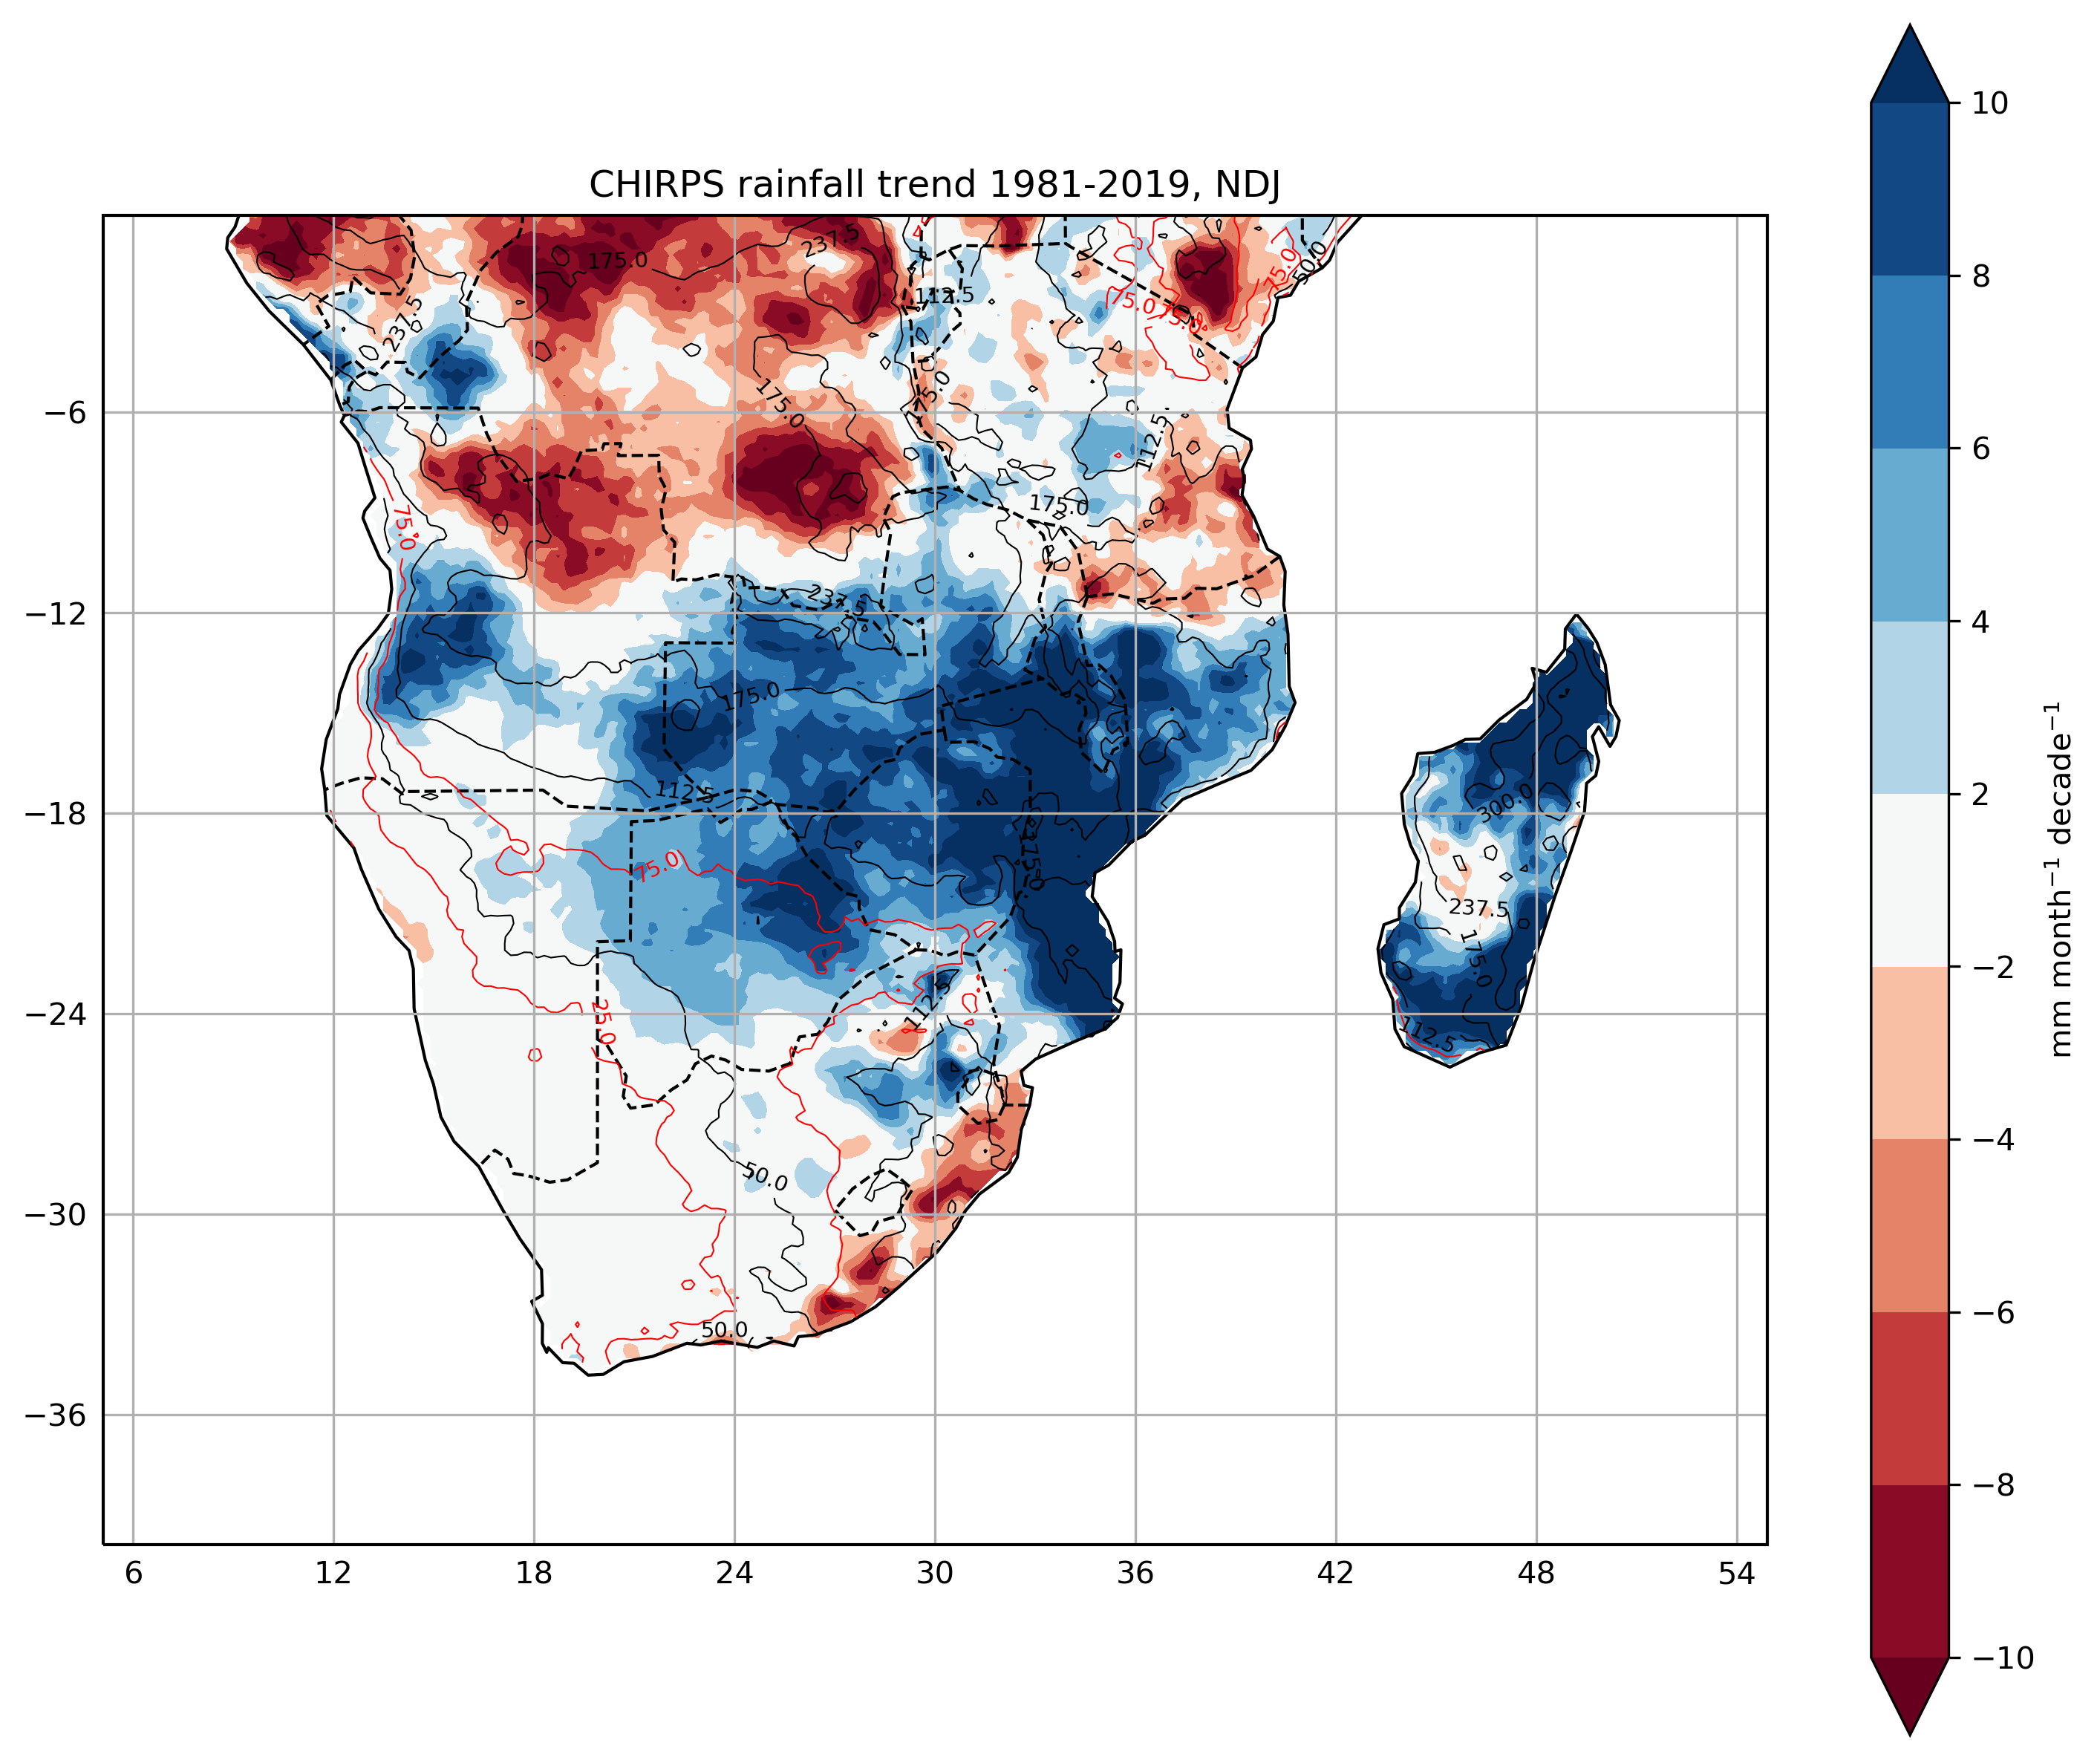

In [106]:
contour = {'x' : mean_y['longitude'].values, 'y': mean_y['latitude'].values, 'data': clim, 'levels': np.linspace(50, 300, 5)}
contour2 = {'x' : mean_y['longitude'].values, 'y': mean_y['latitude'].values, 'data': clim, 'levels': np.linspace(25, 75, 2)}
draw_map(trend['slope']*10, mean_y['longitude'].values, mean_y['latitude'].values, cmap='RdBu', contour=contour,contour2=contour2, extend='both', levels = [-10,-8,-6,-4,-2,2,4,6,8,10],
        cbar_label='mm month$^{-1}$ decade$^{-1}$', title='CHIRPS rainfall trend 1981-2019, NDJ')


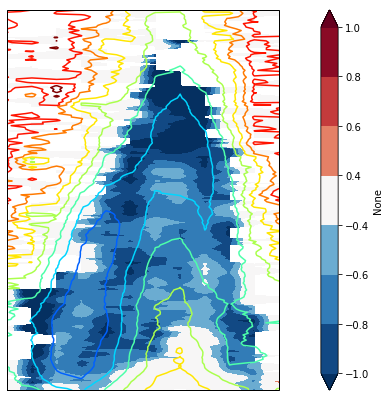

In [96]:
contour = {'x' : mean.month.values, 'y': mean.lat.values, 'data': mean.values.T, 'levels': np.arange(-70,-50,2), 'cmap':'jet'}
draw_map(trend['slope'], trend.month, trend.lat, cmap='RdBu_r', contour=contour, levels=[-1,-0.8,-0.6,-0.4,0.4,0.6,0.8,1], extend='both')

In [103]:
ar = xr.open_dataarray(cnst.GRIDSAT + 'aggs/SAbox_meanT-50_hov_5000km2.nc')

In [104]:
trend=calc_trend(ar)

Entering trend calc


/home/ck/pythonWorkspace/proj_CEH/utils/u_mann_kendall.py:59: RuntimeWarning: invalid value encountered in less_equal
  tmp[np.where(np.fabs(tmp) <= eps)] = 0.
/home/ck/pythonWorkspace/proj_CEH/utils/u_mann_kendall.py:73: RuntimeWarning: invalid value encountered in less
  idx =  np.where(np.fabs(x - ties[k]) < eps)[0]


In [105]:
trend['slope'].values = trend['slope'].values*10
#trend['slope'].values[trend['pval'].values>0.05] = 0

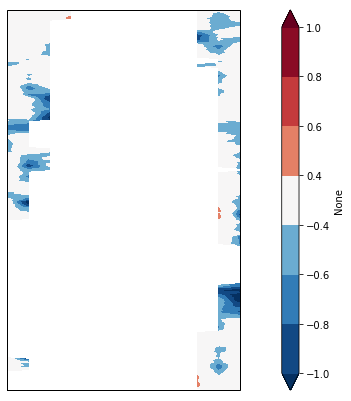

In [106]:
contour = {'x' : mean.month.values, 'y': mean.lat.values, 'data': mean.values.T, 'levels': np.arange(-70,-50,2), 'cmap':'jet'}
draw_map(trend['slope'], trend.month, trend.lat, cmap='RdBu_r', levels=[-1,-0.8,-0.6,-0.4,0.4,0.6,0.8,1], extend='both')